### CNN with Transfer Learning on MobileNet

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from LossLearningRateScheduler import LossLearningRateScheduler

from sutils import *

import gc
import os, json
from os import walk
from glob import glob

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

#from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet

from keras import backend as K

import tensorflow as tf

import pickle
import numpy as np
import math


# Setup multiprocessing pool
# Do this early, as once images are loaded into memory there will be Errno 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.3.0
2.0.8


In [3]:
# for machines with gpu
limit_gpu_mem()

In [5]:
# set path for easy working
#path = "/home/paperspace/CNNProject/dataset/"
path = "//Users/ianlo/Documents/Data Analyitcs & Data Science/Deep Learning Developer Course/CNNProject/dataset/"

os.chdir(path)

In [6]:
no_of_epochs = 50
# step size is important because within each epoch, the no of steps is run. And for each step, it will
# take the batch_size and then the ImageDataGenerator will randomly perturb the image. If we have a large
# step_size and batch_size then the ImageDataGenerator should be able to perturb more images
step_size = 512
batch_size = 32
sed = 12345

In [7]:
# # extend ImageDataGenerator class if we need to call fit before flow_from_directory
# class FixedImageDataGenerator(ImageDataGenerator):
#     def standardize(self, x):
#         if self.featurewise_center:
#             x = ((x/255.) - 0.5) * 2.
#         return x

# # This will do preprocessing and realtime data augmentation:
# datagen = FixedImageDataGenerator(
#     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#     horizontal_flip=True,  # randomly flip images
#     vertical_flip=False)  # randomly flip images

datagen = image.ImageDataGenerator(
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    shear_range=0.3, 
    zoom_range=0.3,
    rescale=1./255, # scale the images
    fill_mode='nearest')

# this will subtract the mean values for inceptionv3 over imagenet
datagen.mean=np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape(1,1,3)

In [8]:
# Prepare images for training in batches
# NB: They must be in subdirectories named based on their category
batches = get_batches(path+'train', gen=datagen, target_size=(224,224), batch_size=batch_size, shuffle=True, seed=sed)
val_batches = get_batches(path+'valid', gen=datagen, target_size=(224,224), batch_size=batch_size*5, shuffle=False, seed=sed)

# create index to class mapping
index_class = {}
for fclass in val_batches.class_indices.keys():
    index_class[val_batches.class_indices.get(fclass)] = fclass

index_class

Found 14653 images belonging to 17 classes.
Found 1645 images belonging to 17 classes.


{0: 'bak_kut_teh',
 1: 'braised_duck_rice',
 2: 'char_kway_teow',
 3: 'chili_crab',
 4: 'hokkien_mee',
 5: 'kueh_pie_tee',
 6: 'kway_chap',
 7: 'mee_goreng',
 8: 'mee_rebus',
 9: 'nasi_lemak',
 10: 'popiah',
 11: 'prawn_noodle',
 12: 'roast_chicken_rice',
 13: 'roti_prata',
 14: 'satay',
 15: 'wanton_mee',
 16: 'white_chicken_rice'}

In [9]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    #keys = labels_dict.keys()
    class_weight = dict()

    #for key in keys:
    for key, value in labels_dict.items():
        #score = math.log(mu*total/float(labels_dict[key]))
        score = math.log(mu*total/float(value))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# random labels_dict
labels_dict = {0: 825, 1: 619, 2: 1592, 3: 825, 4: 921, 5: 635, 6: 747, 7: 900,
               8: 726, 9: 1028, 10: 593, 11: 951, 12: 443, 13: 978, 14: 763,
               15: 1107, 16: 1026}

classweights = create_class_weight(labels_dict, mu=0.25)
classweights

{0: 1.4924954325026616,
 1: 1.7797735461527466,
 2: 1.0,
 3: 1.4924954325026616,
 4: 1.3824187825820358,
 5: 1.754253819944651,
 6: 1.5918136337045254,
 7: 1.405484055513032,
 8: 1.6203288040125465,
 9: 1.2725083728222322,
 10: 1.8226844198396173,
 11: 1.3503647562919523,
 12: 2.1143090487922067,
 13: 1.3223691488025253,
 14: 1.5706207875528857,
 15: 1.1984698861287058,
 16: 1.2744557931066278}

This will download the ImageNet weights for MobileNet

In [10]:
# create the base pre-trained model
#base_model = MobileNet(weights='imagenet', include_top=False)

base_model = MobileNet(input_shape=(224, 224, 3),
                       alpha=1.0,
                       depth_multiplier=1,
                       dropout=1e-3,
                       include_top=False,
                       weights='imagenet',
                       input_tensor=None,
                       pooling=None,
                       classes=1000)

#base_model = keras.applications.mobilenet.MobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)


In [11]:
# summary of the base model
#base_model.summary()

This is where we can add our own structure after the last layer of the pre-trained model

In [12]:
from keras.layers.advanced_activations import LeakyReLU, PReLU

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer with batch normalization
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# try batch normalization before and after activation layer
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)

# over fit the model first then slowly introduce dropout to tune the validation set
x = Dropout(0.20, name='dropout_1')(x)
x = Dense(2048, activation='relu')(x)
#x = Dropout(0.20, name='dropout_2')(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.20, name='dropout_3')(x)
#x = Dense(1024, activation='relu')(x)


# and a logistic layer -- let's say we have 7 classes
predictions = Dense(17, activation='softmax')(x)

In [13]:
# this is the model we will train
#del model
gc.collect()

model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers. This is because we want to only train the specific layers we added
for layer in base_model.layers:
    layer.trainable = False
    #print(layer.name)

In [15]:
# investigate different optimizers
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [16]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
test = batches.next()

len(test[1][0])
test[1][2]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.], dtype=float32)

In [17]:
from keras.callbacks import LearningRateScheduler
import math

# linear learning rate adjustment based on even epochs
def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(scheduler)


# linear learning rate adjustment based on each epoch
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', K.get_value(self.model.optimizer.lr))

loss_history = LossHistory()


In [18]:
#hist = model.fit_generator(batches, steps_per_epoch=80, epochs=no_of_epochs,verbose=1,
#                validation_data=val_batches, validation_steps=3, callbacks=[loss_history, lrate])

hist = model.fit_generator(batches,
                           steps_per_epoch=step_size,
                           epochs=no_of_epochs,
                           verbose=1,
                           validation_data=val_batches,
                           validation_steps=3,
                           class_weight=classweights,
                           callbacks = [keras.callbacks.History(),
                                        LossLearningRateScheduler(base_lr = 0.001,
                                                                  lookback_epochs = 3,
                                                                  decay_multiple = 0.75)])

Setting learning rate to 0.001
Epoch 1/50
512/512 [==============================] - 307s - loss: 2.6982 - acc: 0.5447 - val_loss: 1.1115 - val_acc: 0.6583
Setting learning rate to 0.001
Epoch 2/50
512/512 [==============================] - 243s - loss: 1.4848 - acc: 0.6784 - val_loss: 0.9810 - val_acc: 0.6958
Setting learning rate to 0.001
Epoch 3/50
512/512 [==============================] - 239s - loss: 1.3130 - acc: 0.7156 - val_loss: 0.7874 - val_acc: 0.7610
Setting learning rate to 0.001
Epoch 4/50
512/512 [==============================] - 262s - loss: 1.2132 - acc: 0.7352 - val_loss: 0.6923 - val_acc: 0.8021
Learning rate: 0.001
Epoch 5/50
512/512 [==============================] - 271s - loss: 1.1490 - acc: 0.7446 - val_loss: 0.9761 - val_acc: 0.6979
Changing learning rate from 0.001 to 0.000750000035623
Epoch 6/50
512/512 [==============================] - 291s - loss: 1.0505 - acc: 0.7692 - val_loss: 0.7741 - val_acc: 0.7775
Changing learning rate from 0.00075 to 0.000562500

In [19]:
metrics = model.evaluate_generator(val_batches, 10, 10, workers=1, use_multiprocessing=True)
print("model accuracy:",metrics[1])

model accuracy: 0.811320767248


['seaborn-notebook', 'seaborn-colorblind', 'seaborn-muted', 'ggplot', '_classic_test', 'seaborn-white', 'seaborn-poster', 'seaborn', 'Solarize_Light2', 'seaborn-whitegrid', 'grayscale', 'seaborn-pastel', 'fast', 'seaborn-dark', 'fivethirtyeight', 'seaborn-deep', 'seaborn-ticks', 'dark_background', 'seaborn-bright', 'seaborn-talk', 'seaborn-darkgrid', 'seaborn-dark-palette', 'classic', 'seaborn-paper', 'bmh']


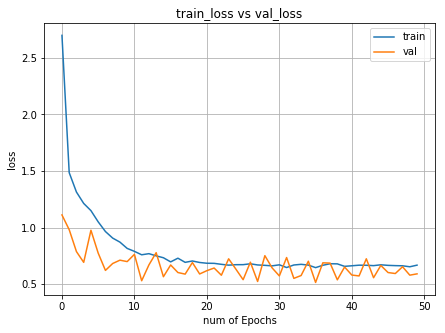

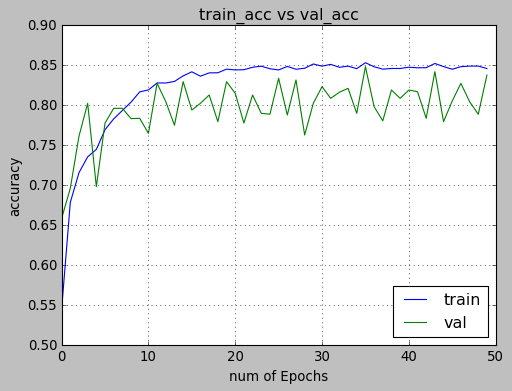

In [36]:
# visualizing losses and accuracy

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(no_of_epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print(plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [20]:
# save the model
model.save('../food-model-mobilenet.hdf5')

In [18]:
# reload model to ensure that the model is saved successfully and can be subsequently read
# need to load the mobilenet model this way

#model = load_model('food-model.hdf5')

from keras.utils.generic_utils import CustomObjectScope

with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.mobilenet.DepthwiseConv2D}):
    model = load_model('../food-model-mobilenet.hdf5')

In [20]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

name = 'wanton_mee-21.jpg'
image_path = "./valid/wanton_mee/"
#image_path = "./valid/white_chicken_rice/"
#image_path = "./valid/bak_kut_teh/"
#image_path = "./valid/braised_duck_rice/"
#image_path = "./valid/mee_rebus/"

img_path = os.path.join(image_path, name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = preprocess_input(x, data_format='channels_first')
x *= 1./255
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


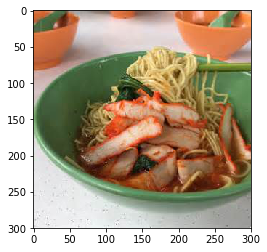

In [21]:
def show_image(name):
    img_path = os.path.join(image_path, name)
    img=mpimg.imread(img_path)
    plt.imshow(img)
    
show_image(name)

Predict the image and return class label

In [23]:
preds = model.predict(x)
result = index_class.get(np.argmax(preds))
print(result)

wanton_mee


In [24]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
# run the model through the validation data
valgen = image.ImageDataGenerator(
    rescale=1./255, # scale the images
)

val_batches = get_batches(path+'valid', gen=valgen, batch_size=1, target_size=(224,224), shuffle=False, seed=sed)

preds = model.predict_generator(val_batches, len(val_batches.filenames)//1, verbose=1)

Found 1644 images belonging to 17 classes.
1644/1644 [==============================] - 24s    


In [30]:
# create list of predicted classes
preds = np.argmax(preds, axis=1)

In [31]:
# get validation classes (ground truth label)
from sklearn.preprocessing import LabelEncoder

y_valid = [filename[:filename.find('/')] for filename in val_batches.filenames]

le = LabelEncoder()
y_valid = le.fit_transform(y_valid)

In [32]:
# get class names for confusion matrix
class_names = [fclass for fclass in val_batches.class_indices.keys()]

Confusion matrix, without normalization
[[ 98   0   0   0   0   0   0   0   1   0   0   0   0   1   0   0   1]
 [  3  52   3   1   0   0   6   0   0   1   1   0   0   1   0   2   1]
 [  0   1 161   1   1   0   4  10   2   0   0   0   0   0   0   1   0]
 [  0   2   1  85   0   0   0   1   0   0   0   1   0   1   0   1   0]
 [  1   0   1   0  86   0   0   3   1   0   0   6   0   0   0   2   1]
 [  0   0   1   1   0  64   0   0   0   0   0   1   0   0   3   0   1]
 [  1   5   0   0   0   0  74   0   1   0   0   1   0   0   1   0   0]
 [  0   0   2   0   1   0   1  92   0   2   0   0   0   1   0   2   0]
 [  0   0   2   0   1   0   1   2  72   0   0   2   0   0   0   1   0]
 [  0   1   0   0   0   0   2   2   0  97   1   3   2   0   0   0   3]
 [  0   0   1   0   0   2   0   0   0   0  61   0   1   0   1   1   0]
 [  1   0   1   0   1   0   2   2   5   0   0  81   0   0   1   5   2]
 [  0   1   0   1   0   0   1   1   1   1   0   0  31   1   1   1  11]
 [  0   0   0   2   1   0   0   0   1

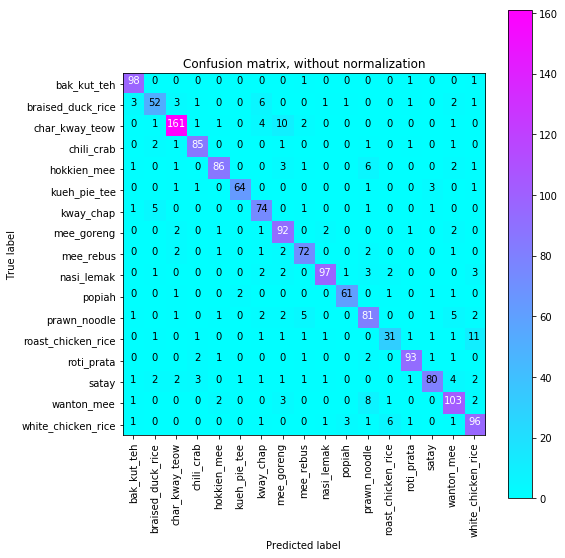

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, preds)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 8)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()